In [1232]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import math
import copy
import pandas as pd

from enum import Enum
from scipy.stats import truncnorm

import seaborn as sns
sns.set_color_codes('bright')


# Auction Simulation


## Enums and Static Values


In [1233]:
class BIDDER_TYPE(Enum):
    influencer = 1
    reactor = 2


In [1234]:
new_line = '\n'
new_line_space = '\n' + '   '


## Helper Functions


In [1235]:
def get_truncated_normal(mean, std, count, low=0, upp=1):
    a, b = (low - mean) / std, (upp - mean) / std

    return truncnorm.rvs(
        a, b, loc=mean, scale=std, size=count)


In [1236]:
def get_bidder_type(beta_self, std):
    std_self = (1/math.sqrt(beta_self)) / std
    if std_self < 0.5:
        return BIDDER_TYPE.reactor
    
    return BIDDER_TYPE.influencer

In [1237]:
def average_value(values):
    return sum(values) / len(values)


In [1238]:
def calculate_betas(private_info, consensus_bias, desire_coef, risk_coef, std_private_values):
    # beta = 1/std^2
    std_self_coef = average_value([1-private_info, 1-consensus_bias, desire_coef, risk_coef])
    std_others_coef = 1 - std_self_coef

    std_self = std_self_coef * std_private_values
    std_others = std_others_coef * std_private_values
    return 1/math.pow(std_self, 2), 1/math.pow(std_others, 2)


In [1239]:
def get_value_belief_dist(private_value, beta, no_bidders):
    # loc: mean
    # scale: std (sigma)
    # size: how many numbers to generate
    return np.random.normal(loc=private_value, scale=math.sqrt(1/(beta)), size=no_bidders)


In [1240]:
def update_belief_set(bidder, new_bid_amount, no_bidders, time, total_time):
    # what is the probability that this new_bid_amount is correct, given our current assumptions?

    std_others = math.sqrt(1/bidder.beta_others)
    std_self = math.sqrt(1/bidder.beta_self)



    beta_incoming = bidder.beta_others * (time / total_time)

    beta_new = bidder.beta_self + beta_incoming
    mean_new = ((bidder.beta_self/beta_new) * bidder.curr_value) + ((beta_incoming/beta_new) * new_bid_amount)
    
    print("incoming perc: ", beta_incoming / beta_new)
    print("self perc: ", bidder.beta_self / beta_new)

    bidder.curr_value = math.floor(mean_new)
    bidder.beta = beta_new
    bidder.value_belief_distribution = get_value_belief_dist(
        bidder.curr_value, bidder.beta, no_bidders)


### Plotting


In [1241]:
def plot_belief_distributions(belief_sets, title):
    plt.figure(figsize=(20, 12))

    belief_set_df = pd.concat([pd.Series(x) for x in belief_sets], axis=1)

    sns.displot(data=belief_set_df, kind="kde").set(
        title=title, xlabel='Item Value', ylabel='Density')

    plt.show()


## Classes


In [1242]:
class Auction:
    def __init__(self, id, N, T, reserve, start_bid):
        self.id = id

        # static values
        self.N = N
        self.T = T
        self.reserve = reserve
        self.start_bid = start_bid
        self.bidders = None

        # dynamic values
        self.t = 0
        self.curr_bid = start_bid

    def __str__(self) -> str:

        attribute_strings = (
            'id: ' + self.id + new_line_space +
            'no. bidders: ' + str(self.N) + new_line_space +
            'duration: ' + str(self.T) + new_line_space +
            'reserve: ' + str(self.reserve) + new_line
        )

        return (
            'Auction(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [1243]:

class Bidder:
    def __init__(self, name, bidder_type, predef_value, beta_self, beta_others, desire_coef, value_belief_distribution):
        self.name = name
        self.bidder_type = bidder_type  # influencer bidder or reactor
        self.predef_value = predef_value  # bidder's estimated value of item pre-auction

        self.desire_coef = desire_coef # how much does the bidder want the item at the start?
        self.curr_value = predef_value  # bidders updated in-auction value
        self.is_active = True  # all bidders start active
        self.no_bids_submitted = 0 # no bids submitted by bidder
        self.value_belief_distribution = value_belief_distribution # what he thinks other bidder's values are

        # --- beta coefficients ---

        # static
        self.beta_self = beta_self  # how much bidder trusts his original value estimate
        self.beta_others = beta_others  # how much the bidder trusts incoming information

        # dynamic
        self.beta = beta_self # how much bidder trusts his current value estimate

    

    def __str__(self) -> str:

        attribute_strings = (
            'name: ' + self.name + new_line_space +
            'predef_value: ' + str(self.predef_value) + new_line_space +
            'curr_value: ' + str(self.curr_value) + new_line_space +
            'beta_self: ' + str(self.beta_self) + new_line_space +
            'beta: ' + str(self.beta) + new_line_space +
            'beta_others: ' + str(self.beta_others) + new_line_space +
            'bidder_type: ' + str(self.bidder_type) + new_line
        )

        return (
            'Bidder(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [1244]:
class Bid:
    def __init__(self, amount: int, bidder: Bidder):
        self.amount = amount
        self.bidder = bidder

    def __str__(self) -> str:
        return 'Bid(amount=' + str(self.amount) + ' ,bidder=' + str(self.bidder) + ')'


## Simulation Functions


In [1245]:
def get_bidder_bid(curr_bid: Bid, curr_time: int, bidder: Bidder, duration: int):
    bid_amount = 0

    is_time_to_bid = (
        (bidder.bidder_type == BIDDER_TYPE.influencer)
        |
        (
            # bids if time 90% of T or bid 90% of value
            (bidder.bidder_type == BIDDER_TYPE.reactor)
            &
            ((curr_time > 0.9 * duration) |
             (curr_bid.amount > bidder.curr_value * 0.9))
        )
    )

    # influencer vs. reactor
    if (is_time_to_bid & (curr_bid.bidder != bidder) & (curr_bid.amount < bidder.curr_value)):
        # bid random btw. current bid and halfway from current bid to own value
        bid_amount = rd.randint(curr_bid.amount, math.floor(
            curr_bid.amount + (bidder.curr_value - curr_bid.amount) / 2))

    return bid_amount


In [1246]:

def run_auction(auction):
    auction.curr_bid = auction.start_bid
    auction.t = 0
    no_more_bids = False

    while ((auction.t < auction.T) & (not no_more_bids)):
        bids = []

        for bidder in auction.bidders:
            bid_amount = get_bidder_bid(
                auction.curr_bid, auction.t, bidder, auction.T)

            if (bid_amount > auction.curr_bid.amount):
                bids.append(Bid(bid_amount, bidder))

        if (len(bids) > 0):
            max_bid = max(bids, key=lambda bid: bid.amount)
            auction.curr_bid = max_bid
            auction.curr_bid.bidder.no_bids_submitted += 1
            for bidder in auction.bidders:
                update_belief_set(
                    bidder=bidder, new_bid_amount=auction.curr_bid.amount, no_bidders=auction.N, time=auction.t, total_time=auction.T)

        else:
            no_more_bids = True

        auction.t += 1
        # print('avg beta: ', average_value(list(map(lambda bidder: bidder.beta, auction.bidders))))
        # print('avg beta_self: ', average_value(list(map(lambda bidder: bidder.beta_self, auction.bidders))))
        # print('avg beta_others: ', average_value(list(map(lambda bidder: bidder.beta_others, auction.bidders))))

    return auction.curr_bid


In [1247]:
def run_simulation(no_iterations):
    # mean and standard deviation of private values
    # std: how affiliated are the private values?? TODO!!
    avg = 5000
    std = avg * 0.2
    winning_bids = []
    all_original_bidders = []
    all_final_bidders = []
    for i in range(0, no_iterations):
        auction = Auction(id='b'+str(i+1), N=10, T=30,
                          reserve=4000, start_bid=Bid(0, None))

        bidder_private_values = [math.floor(x) for x in get_truncated_normal(
            mean=avg, std=std, count=auction.N, low=0, upp=1000000)]
        bidder_private_infos = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_consensus_bias = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_desires = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_risk_coefs = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)

        bidders = []
        for i in range(0, auction.N):
            beta_self, beta_others = calculate_betas(
                bidder_private_infos[i], bidder_consensus_bias[i], bidder_desires[i], bidder_risk_coefs[i], std)
            bidder_type = get_bidder_type(beta_self, std)

            bidders.append(Bidder(
                name='b'+str(i+1),
                bidder_type=bidder_type,
                predef_value=bidder_private_values[i],
                beta_self=beta_self,
                beta_others=beta_others,
                desire_coef=bidder_desires[i],
                value_belief_distribution=get_value_belief_dist(bidder_private_values[i], beta_self, auction.N)))

        original_bidders = copy.deepcopy(bidders)
        all_original_bidders.append(original_bidders)

        auction.bidders = bidders

        winning_bids.append(run_auction(auction))
        all_final_bidders.append(auction.bidders)

    return winning_bids, all_final_bidders, all_original_bidders


## Simulation


In [1248]:
winning_bids, all_final_bidders, all_original_bidders = run_simulation(3)


incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.0
self perc:  1.0
incoming perc:  0.043198447489011006
self perc:  0.956801552510989
incoming perc:  0.021988514813989623
self perc:  0.9780114851860104
incoming perc:  0.03717397755603099
self perc:  0.962826022443969
incoming perc:  0.04303230499751011
self perc:  0.9569676950024899
incoming perc:  0.03430636802338938
self perc:  0.9656936319766106
incoming perc:  0.008095933730884703
self perc:  0.9919040662691153
incoming perc:  0.06923653657157529
self perc:  0.9307634634284246
incoming perc:  0.01785963976482131
self perc:  0.9821403602351786
incoming perc:  0.010546990185789456
self perc:  0.9894530098142106
incoming perc:  0.23906519026055922

In [1249]:

# for i in range(0,len(all_original_bidders)):
#     plot_belief_distributions(list(map(lambda bidder: bidder.value_belief_distribution,
#                                  all_original_bidders[i])), 'Bidder\'s (Original) Belief Distributions')
#     plot_belief_distributions(list(map(lambda bidder: bidder.value_belief_distribution,
#                                        all_final_bidders[i])), 'Bidder\'s (Final) Belief Distributions')


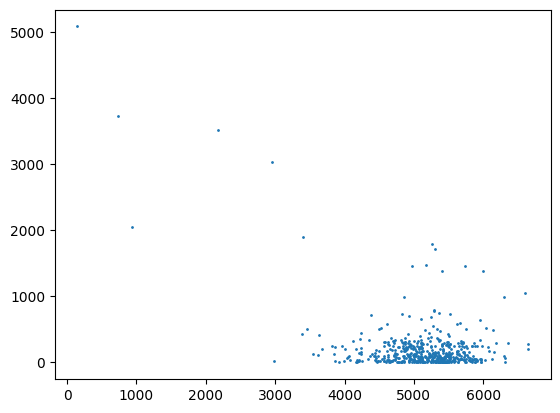

In [1250]:
# ---WINNING BID AMOUNT---
winning_bid_amounts = list(map(lambda bid: bid.amount, winning_bids))

# ---WINNING BIDDER UTILITY---
winning_bidder_utility = list(
    map(lambda bid: bid.bidder.curr_value - bid.amount, winning_bids))

#pd.value_counts(winning_bidder_utility).sort_index().plot.bar()

plt.scatter(x=winning_bid_amounts, y=winning_bidder_utility, s=1)
plt.show()


<AxesSubplot: >

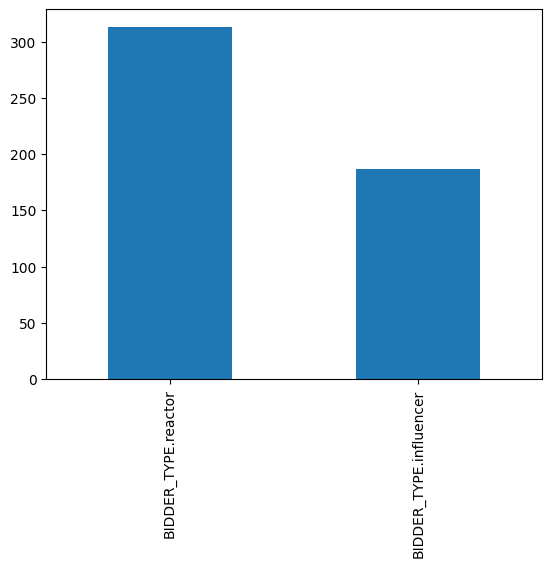

In [1251]:
# ---WINNING BIDDER TYPE---

winning_bidder_types = list(
    map(lambda bid: bid.bidder.bidder_type, winning_bids))

pd.value_counts(winning_bidder_types).plot.bar()


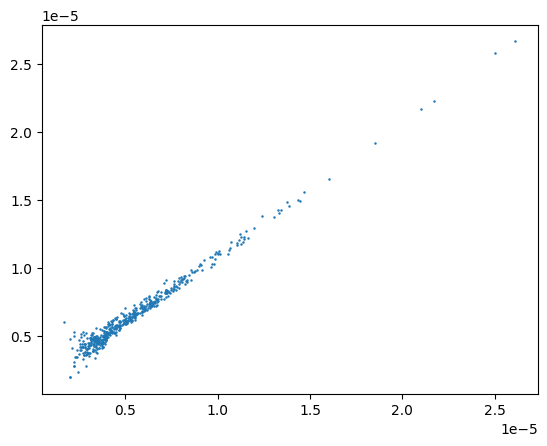

In [1252]:
# ---WINNING BIDDER UTILITY---
winning_bidder_beta_self = list(
    map(lambda bid: bid.bidder.beta_self, winning_bids))

winning_bidder_beta = list(
    map(lambda bid: bid.bidder.beta, winning_bids))


plt.scatter(x=winning_bidder_beta_self, y=winning_bidder_beta, s=0.6)
plt.show()

<AxesSubplot: >

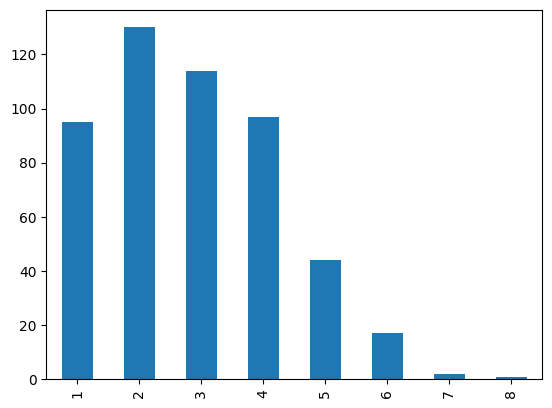

In [1253]:
# ---WINNING BIDDER NO BIDS SUBMITTED---
winning_bidder_bid_count = list(
    map(lambda bid: bid.bidder.no_bids_submitted, winning_bids))

pd.value_counts(winning_bidder_bid_count).sort_index().plot.bar()


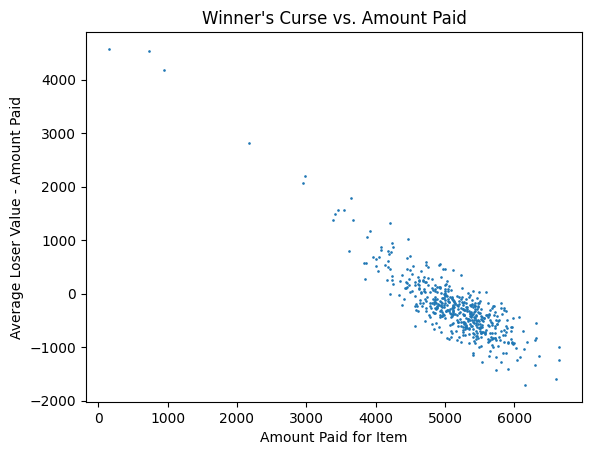

In [1263]:

winner_curses = []
winner_amounts = []

for i in range(0,len(winning_bids)): 
    winning_bidder = winning_bids[i].bidder
    all_but_winner = filter(lambda bidder: bidder.name != winning_bidder.name, all_original_bidders[i])
    average_loser_value = average_value(list(map(lambda losing_bidder: losing_bidder.curr_value, all_but_winner)))
    winner_curse = average_loser_value - winning_bids[i].amount
    winner_curses.append(winner_curse)
    winner_amounts.append(winning_bids[i].amount)

plt.scatter(x=winner_amounts, y=winner_curses, s=0.8)
plt.title('Winner\'s Curse vs. Amount Paid')
plt.xlabel('Amount Paid for Item')
plt.ylabel('Average Loser Value - Amount Paid')
plt.show()


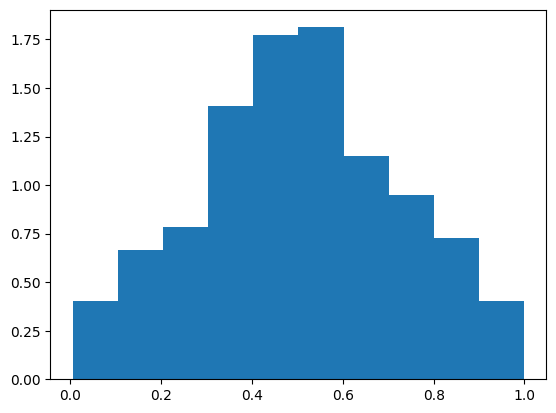

In [ ]:
foo = get_truncated_normal(
            mean=0.5, std=0.25, count=500)

plt.hist(foo, density=True)
plt.show()